In [1]:
import math

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from dataset_loader import load_from_file

#SET_DST = 'cache/dots_100000.pickle'
SET_DST = 'cache/tracks_100000.pickle'
#SET_DST = 'cache/worms_100000.pickle'
#SET_DST = 'cache/artifacts_100000.pickle'

In [2]:
def as_mnist(images):
    c, w, h = images.shape
    w1 = int((w-28)/2)
    h1 = int((h-28)/2)

    return images[:,w1:w1+28,h1:h1+28]

def load_as_mnist(src):
    images, augmented = load_from_file(src)
    return as_mnist(images), as_mnist(augmented)

In [3]:
"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [5]:
"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [6]:
"""
## Define the VAE as a `Model` with a custom `train_step`
"""


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
"""
## Train the VAE
"""

# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# _, mnist_digits_dots = load_as_mnist(DOTS_DST)
# _, mnist_digits_tracks = load_as_mnist(TRACKS_DST)
# _, mnist_digits_worms = load_as_mnist(WORMS_DST)
# _, mnist_digits_artifacts = load_as_mnist(ARTIFACTS_DST)
# mnist_digits = np.concatenate([mnist_digits_dots, mnist_digits_tracks, mnist_digits_worms, mnist_digits_artifacts], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1)

def train_vae(src):
    data, _ = load_as_mnist(src)
    data = np.expand_dims(data, -1)
    vae = VAE(encoder, decoder)
    vae.compile(optimizer=keras.optimizers.Adam())
    vae.fit(data, epochs=30, batch_size=128)
    return vae

vae_dots = train_vae(SET_DST)
#vae_tracks = train_vae(TRACKS_DST)
#vae_worms = train_vae(WORMS_DST)
#vae_artifacts = train_vae(ARTIFACTS_DST)

Epoch 1/30
24/24 [==============================] - 2s 14ms/step - loss: 472.3901 - reconstruction_loss: 339.7713 - kl_loss: 12.3340
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 47.3256 - reconstruction_loss: 35.6401 - kl_loss: 2.4439
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 24.1883 - reconstruction_loss: 22.9926 - kl_loss: 0.1858
Epoch 4/30
24/24 [==============================] - 0s 11ms/step - loss: 21.0538 - reconstruction_loss: 20.7278 - kl_loss: 0.1066
Epoch 5/30
24/24 [==============================] - 0s 11ms/step - loss: 20.2388 - reconstruction_loss: 19.9287 - kl_loss: 0.0707
Epoch 6/30
24/24 [==============================] - 0s 11ms/step - loss: 19.5871 - reconstruction_loss: 19.3406 - kl_loss: 0.0492
Epoch 7/30
24/24 [==============================] - 0s 12ms/step - loss: 19.1175 - reconstruction_loss: 19.0532 - kl_loss: 0.0362
Epoch 8/30
24/24 [==============================] - 0s 11ms/step - loss: 18.6845 - reco

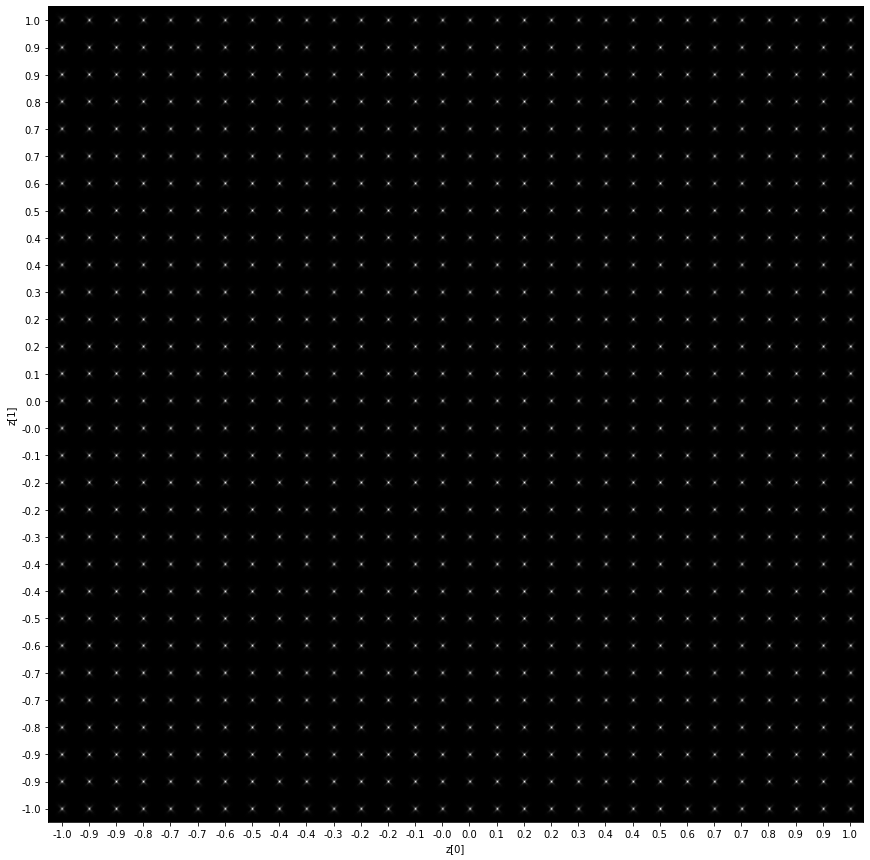

In [8]:
"""
## Display a grid of sampled digits
"""

import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae_dots)
#plot_latent_space(vae_tracks)
#plot_latent_space(vae_worms)
#plot_latent_space(vae_artifacts)

In [9]:
"""
## Display how the latent space clusters different digit classes
"""


def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


#(x_train, y_train), _ = keras.datasets.mnist.load_data()
#x_train = np.expand_dims(x_train, -1).astype("float32") / 255

#plot_label_clusters(vae, x_train, y_train)